# PwC Challenge Data Scientist Jr


## Table Of Content

- [Load & Preprocess Data](#load--preprocess-data)
- [Training model](#training-the-model-and-getting-the-metrics)
- [Obtaining Bootstrap CI](#obtaining-bootstrap-confidence-intervals-for-the-metrics)
- [Comparison with DummyRegressor](#comparison-with-baseline-model)
- [Cross-Validation](#cross-validation)
- [API](#making-predictions-by-api)
- [Technical Conditions](#technical-conditions)

<hr></hr>

## Linear model for salary prediction

* We will explore the process of predicting salary based on several features (gender, education level, and years of experience). We start by preprocessing the data, including handling categorical variables and scaling the features, to ensure that the model works optimally.
* We use a <b>linear regression model</b> to predict salary based on the preprocessed features. The model is trained using a small dataset, and its performance is evaluated using confidence intervals of RMSE and R-squared and for the assumptions of linear regression we use Shapiro-Wilk, Q-Q Plot, and more.
* The trained model is deployed as an API using FastAPI. This allows users to make predictions by sending requests with the correct data gender, education level, and years of experience. The API returns the predicted salary as a response.

Variables in the model:
* <b>Gender</b>
* <b>Education Level</b>
* <b>Years Of Experience</b>

<b>Dropped variables:
* Age: This variable was highly correlated with Salary and moderately correlated with "Years of Experience" (indicated by VIF test) and we found that Years of Experience was a more direct and relevant predictor of salary.
* Job Title: Although the job title can affect salary, it was excluded due to the large number of possible categories (174 categories of 375 rows => high dimensionality), which would add complexity to the model</b>

### Load & Preprocess data

In [1]:
from LinearRegression.preprocessing import load_and_preprocess_data

X_train, X_test, y_train, y_test, scaler = load_and_preprocess_data('data/DataTransformed.csv')

### Training the model and getting the metrics

In [2]:
from LinearRegression.my_model import train_and_evaluate_model

linear_model, mse, rmse, r2_adjusted = train_and_evaluate_model(X_train, X_test, y_train, y_test)

Saving the model for API <b>(Execute when making changes to the model)</b>:

In [3]:
# Saving the model

#import pickle
#with open("api/linear_model.pkl", "wb") as f:
#    pickle.dump(linear_model, f)

#with open("api/scaler.pkl", "wb") as f:
#    pickle.dump(scaler, f)

### Obtaining Bootstrap Confidence Intervals for the metrics

In [ ]:
from LinearRegression.bootstrap import bootstrap_metrics

mse_interval, r2_adjusted_interval = bootstrap_metrics(linear_model, X_train, y_train, X_test, y_test)
print(f"RMSE 95% confidence interval: ({float(mse_interval[0]):.2f}, {float(mse_interval[1]):.2f})")
print(f"R²-adjusted 95% confidence interval: ({float(r2_adjusted_interval[0]):.4f}, {float(r2_adjusted_interval[1]):.4f})")

RMSE 95% confidence interval: (15213.87, 16322.27)


NameError: name 'r2_interval' is not defined

For our linear regression model we use 2 metrics <b>Root Mean Squared Error</b> (RMSE) and <b>R-Squared</b> (R²) for its evaluation:

- <b>RMSE</b>: Measures the average deviation of the predicted values from the actual values in the provided dataset. <b>At a 95% confidence level, predicted salaries deviate, on average, between $14000 and $16500</b>

- <b>R²</b>: Explains the proportion of variance in the target variable that can be explained by our trained model, useful for check the overall fit of the model. <b>At a 95% confidence level, the model is able to explain between 88% and 90% of the variance in the salary</b>

### Comparison with baseline model

In [5]:
from LinearRegression.dummy import get_dummy_regressor

dummy_rmse, dummy_r2 = get_dummy_regressor(X_train, y_train, X_test, y_test)
print("-- Dummy Regressor --")
print(f"RMSE: {dummy_rmse}")
print(f"R²: {dummy_r2}")

-- Dummy Regressor --
RMSE: 48427.36377096139
R²: -0.005673557621578507


The trained model shows a substantial improvement over the Dummy Regressor, by both lower RMSE and higher R², <b>confirming that the model is indeed learning from the data and providing good predictions</b>

### Cross-Validation

In [6]:
from LinearRegression.cross_validation import cross_validate_model

rmse_cv, r2_cv = cross_validate_model(linear_model, X_train, y_train, cv=5)
print("-- CROSS VALIDATION --")
print(f"RMSE 95% confidence interval: ({rmse_cv[0]:.2f}, {rmse_cv[1]:.2f})")
print(f"R²-adjusted 95% confidence interval: ({r2_cv[0]:.4f}, {r2_cv[1]:.4f})")

-- CROSS VALIDATION --
RMSE 95% confidence interval: (14049.09, 20171.99)
R² 95% confidence interval: (0.8449, 0.9077)


* The model performs fairly well, with <b>R² values above 0.88 and RMSE values in the range of $13958 to $17937.</b>
* The model seems to capture a large portion of the variance in salary predictions but there is still room for improvement due to the relatively wide confidence interval.
* <b>Overall, the model shows strong predictive power</b>

<hr></hr>

### Making Predictions by API

We trained a linear regression model using the provided data, where the features used were:

* <b>Gender</b>: The gender of the person (Male/Female).
* <b>Education Level</b>: The level of education (Bachelor's, Master's, PhD).
* <b>Years of Experience</b>: Years of work experience.

The model was trained using a scaler to ensure that the features were normalized. After training, both the model and scaler were saved as .pkl files to be used in the API (Made with FastAPI).

<b>Important Considerations:</b>

* The API is designed to handle valid inputs, and if any value is incorrect (such as an unmapped value for gender or education level), the API will return an error.
* The model was trained with the same set of features that are passed to the API to ensure that the results are accurate and consistent.

<i>Before running the chunk below, start the api via terminal: uvicorn api.main:app --reload</i>

In [8]:
import requests

url = "http://127.0.0.1:8000/predict/"

# Data 
data = {
    "gender": "Male",             # "Male" o "Female"
    "education_level": "Bachelor's", # "Bachelor's", "Master's", "PhD"
    "years_of_experience": 5
}

#Make the prediction
response = requests.post(url, json=data)

if response.status_code == 200:
    print("Predicted Salary:", response.json())
else:
    print(f"Error: {response.status_code}")
    print(response.text)


Predicted Salary: {'predicted_salary': 67361}


<hr></hr>

### Technical Conditions

<b>The model's predictions are valid and reliable</b>

<b>1- Linearity</b> ✅

Linearity can be checked in EDA.ipynb with the pairplot and correlation matrix.

<b>2- Homoscedasticity</b> ✅

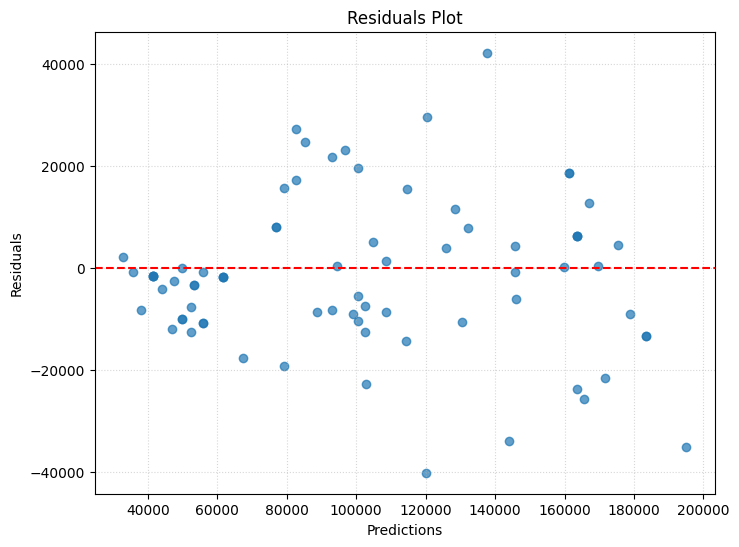

In [161]:
import matplotlib.pyplot as plt

y_pred = linear_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 6)) 
plt.scatter(y_pred, residuals, alpha=0.7)  
plt.axhline(y=0, color='r', linestyle='--')  
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

<b>3- Error Independence</b> ✅

There is no temporal or spatial dependence in the data

<b>4- Normality of errors</b> ✅🛑

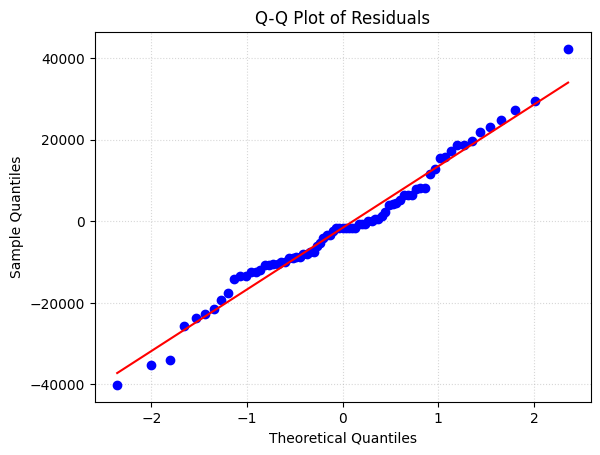

In [ ]:
from scipy.stats import probplot

probplot(residuals, dist="norm", plot=plt)

plt.title("Q-Q Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

In [163]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print(f'Shapiro-Wilk stat: {stat}')
print(f'p-value: {p_value}')

#Checking the p-value
if p_value > 0.05:
    print("Residuals follow a normal distribution (H0 is not rejected).")
else:
    print("The residuals don't follow a normal distribution (H0 is rejected).")

Shapiro-Wilk stat: 0.9803580219074179
p-value: 0.2956444107429801
Residuals follow a normal distribution (H0 is not rejected).


🛑<b>To note, the dataset provided is small which causes the normality tests of the residuals to be sensitive and inconsistent</b>🛑